# Задание 04 

## Различные подходы поиска сообществ

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from numpy import linalg as LA

In [12]:
from collections import Counter
import matplotlib.cm as cm

### **1. Модулярность (3 балла)**
Рассмотрим разбиение сети на два сообщества. Определите максимальное и минимальное значение модулярности сети.

In [13]:
def modularity_matrix(G):
    nodes=list(G.nodes())
    Q=np.zeros([len(nodes), len(nodes)])
    A=nx.adjacency_matrix(G, nodelist=nodes).todense()
    for i in range(len(nodes)):
        for j in range(len(nodes)):
            Q[i,j]=A[i,j]-G.degree[nodes[i]]*G.degree[nodes[j]]/(2*G.number_of_edges())
    return Q

In [14]:
G = nx.karate_club_graph()

In [15]:
Q = modularity_matrix(G)
Q

array([[-1.64102564,  0.07692308, -0.02564103, ...,  0.38461538,
        -1.23076923, -1.74358974],
       [ 0.07692308, -0.51923077,  0.42307692, ..., -0.34615385,
        -0.69230769, -0.98076923],
       [-0.02564103,  0.42307692, -0.64102564, ..., -0.38461538,
         0.23076923, -1.08974359],
       ...,
       [ 0.38461538, -0.34615385, -0.38461538, ..., -0.23076923,
         0.53846154,  0.34615385],
       [-1.23076923, -0.69230769,  0.23076923, ...,  0.53846154,
        -0.92307692, -0.30769231],
       [-1.74358974, -0.98076923, -1.08974359, ...,  0.34615385,
        -0.30769231, -1.8525641 ]])

In [16]:
np.ravel(Q)[np.argmin(Q)]

-1.8525641025641026

In [17]:
np.ravel(Q)[np.argmax(Q)]

0.9487179487179487

In [18]:
w, v = LA.eigh(Q) 
x=np.ravel(v[:,-1])
y_сolor=np.sign(x)

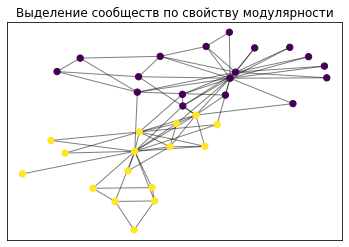

In [19]:
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, node_size=40,
                       cmap=cmap, node_color=y_сolor)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Выделение сообществ по свойству модулярности')
plt.show()

### **2. Алгоритм Лювена (3 балла)** 

Протестируйте алгоритм Лювена на блочно-стохастической модели (см. Семинар 04.02), для этого постройте зависимость метрики качества от параметра модели $\mu$: 
$$
 \mu=\frac{p_{out}}{p_{in}+p_{out}}
$$

Реализация алгоритма Лювена:

In [20]:
import community as co

In [21]:
G = nx.karate_club_graph()

In [22]:
part = co.best_partition(G)
print(part)

{0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 0, 6: 0, 7: 1, 8: 2, 9: 1, 10: 0, 11: 0, 12: 0, 13: 1, 14: 2, 15: 2, 16: 0, 17: 1, 18: 2, 19: 1, 20: 2, 21: 1, 22: 2, 23: 3, 24: 3, 25: 3, 26: 2, 27: 3, 28: 3, 29: 2, 30: 2, 31: 3, 32: 2, 33: 2}


In [23]:
print(co.modularity(part,G))

0.39686061801446415


In [24]:
def block_model(mu, n=100, p_in=0.1):
    A1=np.random.binomial(1, p_in, size=[n,n]) # for edges inside clusters
    A2=np.random.binomial(1, p_in, size=[n,n])
    for i in range(n):
        A1[i,i]=0
        A2[i,i]=0
        for j in range(i+1,n):
            A1[i,j]=A1[j,i]
            A2[i,j]=A2[j,i]
    p_out=(mu*p_in)/(1-mu)
    B=np.random.binomial(1, p_out, size=[n,n]) # for edges between clusters
    A=np.block([[A1,B],[B,A2]])
    G=nx.from_numpy_matrix(A)
    return G

In [25]:
from sklearn.metrics import accuracy_score
def accuracy_score_new(y_true, y_pred):
    a=accuracy_score(y_true, y_pred)
    if(a<0.5):
        return 1-a
    else:
        return a

In [26]:
µ=np.linspace(0.01,0.8,20)
n=100 
p_in=0.2
y_true=[0]*n+[1]*n
modularity = []
accuracy_score_arr = []
for mu in µ:
    G=block_model(mu,n,p_in)
    part = co.best_partition(G)
    mod = co.modularity(part,G)
    modularity.append(mod)
    y_pred=list(part.values())
    accuracy_score_arr.append(accuracy_score_new(y_true, y_pred))

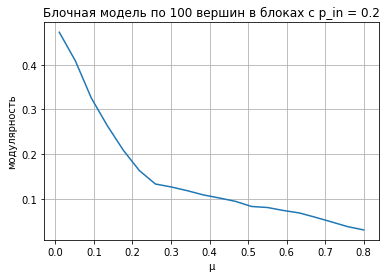

In [27]:
fig = plt.figure()
plt.plot(µ, modularity)
plt.xlabel('µ')
plt.ylabel('модулярность')
plt.title('Блочная модель по '+str(n)+' вершин в блоках с p_in = '+str(p_in))
plt.grid(True)

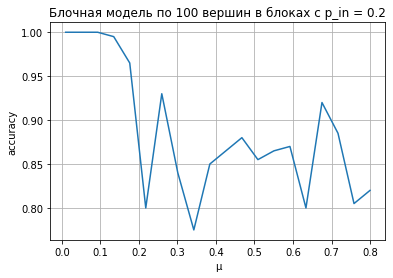

In [28]:
fig = plt.figure()
plt.plot(µ, accuracy_score_arr)
plt.xlabel('µ')
plt.ylabel('accuracy')
plt.title('Блочная модель по '+str(n)+' вершин в блоках с p_in = '+str(p_in))
plt.grid(True)

### **3.  Спектральные методы выделения сообществ (3 балла)**
Будем работать с маленькой сетью социального взаимодействия среди [дельфинов](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.174.3721&rep=rep1&type=pdf). 
* разбейте сеть на два сообщества по собственному вектору матрицы Лапласа;
* сравните с разбиением алгоритмом Лювена

Одинаковы ли эти разбиения? Сделайте визуализацию для наглядности. 

In [29]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving soc-dolphins.txt to soc-dolphins (1).txt
User uploaded file "soc-dolphins.txt" with length 1070 bytes


In [30]:
G=nx.read_edgelist('soc-dolphins.txt', nodetype=int)

In [31]:
L=nx.laplacian_matrix(G).todense()
w, v = LA.eigh(L)
eigenvector = np.ravel(v[:,1])

In [32]:
def find_comm(vect):
    plus = 0
    minus = 0
    for i in vect:
          if i>=0:
              plus+=1
          else:
              minus+=1
    return plus, minus

In [33]:
plus, minus = find_comm(eigenvector)
print("Разбиение спектральным алгоритмом","\nв первом сообществе:", plus, "\nво втором сообществе:", minus)

Разбиение спектральным алгоритмом 
в первом сообществе: 21 
во втором сообществе: 41


In [34]:
partition_dolphins = co.best_partition(G)
values_dolphins = partition_dolphins.values()
counter_dolphins = Counter(values_dolphins)
d_dolphins = dict(counter_dolphins)
print("Разбиение методом Лювена:",d_dolphins)

Разбиение методом Лювена: {0: 8, 1: 18, 2: 12, 3: 18, 4: 6}


In [47]:
print('Количество выделенных сообществ методом Лювена:',len(d_dolphins.keys()))

Количество выделенных сообществ методом Лювена: 5


Спектральный метод в данном случае способен выделить лишь два сообщества, в то время как метод Лювена находит в этом же графе 5 сообществ (в данном эксперименте). 

## Визуализация разбиений:

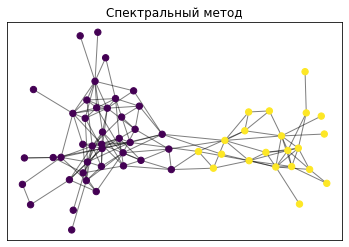

In [35]:
pos = nx.spring_layout(G)
cmap = cm.get_cmap('viridis')
nx.draw_networkx_nodes(G, pos, node_size=40,
                       cmap=cmap, node_color=list(np.sign(eigenvector)))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title('Спектральный метод')
plt.show()

In [36]:
def visual(G,d,s):
  pos = nx.spring_layout(G)
  cmap = cm.get_cmap('viridis', max(d.values()) + 1)
  nx.draw_networkx_nodes(G, pos, d.keys(), node_size=40,
                       cmap=cmap, node_color=list(d.values()))
  nx.draw_networkx_edges(G, pos, alpha=0.5)
  plt.title('метод ' + str(s))
  plt.show()

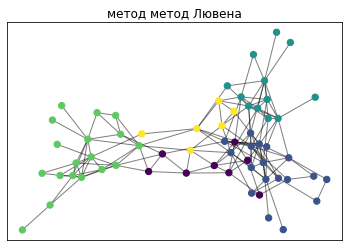

In [37]:
visual(G,partition_dolphins,'метод Лювена')

### **4. Label propagation (3 балла)**
Реализуйте алгоритм [Label propagation](https://en.wikipedia.org/wiki/Label_propagation_algorithm):

* в начальный момент времени всем вершинам ставится в соответствие отдельное сообщество.
* Каждая вершина в графе определяется в то сообщество, которому принадлежит большинство
    его соседей. Если же таких сообществ несколько, то выбирается случайно одно из
    них. Из-за случайности важно на каждой итерации изменять порядок обхода вершин. 
* Алгоритм заканчивает работу, когда нечего изменять: все вершины относятся к тем сообществам, что
    и большинство их соседей.
    
Какие сообщества у дельфинов выделяет ваш алгоритм, сравните со спектральными методами. 

In [38]:
import collections
import random

In [39]:
def der(G):
  nodes = [i for i in G.nodes()]
  d = dict.fromkeys(G.nodes(),0)
  for i in nodes:
    d[i]=i
  random.shuffle(nodes)
  for i in nodes:
    allneib = list(G.neighbors(i))
    metki = [d[i] for i in allneib]
    cmn = collections.Counter(metki).most_common()  
    most = [e for e in cmn if (e[1] == cmn[0][1])]  
    new_metki = random.choice(most)[0]
    d[i] = new_metki
  return d

In [40]:
def der_new(d,G):
  nodes = [i for i in G.nodes()]
  random.shuffle(nodes)
  for i in nodes:
    allneib = list(G.neighbors(i))
    metki = [d[i] for i in allneib]
    cmn = collections.Counter(metki).most_common()  
    most = [e for e in cmn if (e[1] == cmn[0][1])]  
    new_metki = random.choice(most)[0]
    d[i] = new_metki
  return d

In [41]:
def label_propagation(G):
  d1 = der(G)
  d2 = der_new(d1,G)
  a = d1
  b = d2
  while a!=b:
    a=b
    b=der_new(a,G)
  return a

In [42]:
label=label_propagation(G)

In [43]:
values_label = label.values()
counter_label = Counter(values_label)
d_label = dict(counter_label)
print("Разбиение методом label propagation:",d_label)

Разбиение методом label propagation: {43: 10, 46: 11, 52: 13, 28: 7, 58: 12, 39: 4, 1: 4, 38: 1}


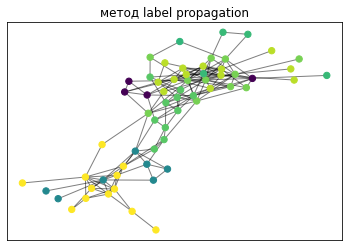

In [44]:
visual(G,label,'label propagation')

In [45]:
print('Количество выделенных сообществ методом label propagation:',len(d_label.keys()))

Количество выделенных сообществ методом label propagation: 8


Сравнивая метод со спектральным, также можно заметить, что label propagation, как и алгоритм Лювена, выделяет больше сообществ. 